# Model25: using category accuracy per users

In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from utils import load_buzz, select, write_result
from features import featurize, get_pos
from containers import Questions, Users, Categories
from nlp import extract_entities

## KMeans

In [41]:
import pickle


questions = pickle.load(open('questions01.pkl', 'rb'))
users = pickle.load(open('users01.pkl', 'rb'))
categories = pickle.load(open('categories01.pkl', 'rb'))

In [42]:
set(users[0].keys()) - set(['cat_uid'])

{'acc_cat_astronomy',
 'acc_cat_biology',
 'acc_cat_chemistry',
 'acc_cat_earth science',
 'acc_cat_fine arts',
 'acc_cat_history',
 'acc_cat_literature',
 'acc_cat_mathematics',
 'acc_cat_other',
 'acc_cat_physics',
 'acc_cat_social studies',
 'acc_ratio_uid',
 'ave_pos_uid'}

In [43]:
from sklearn.preprocessing import normalize

wanted_user_items = list(set(users[0].keys()) - set(['cat_uid']))
X_pos_uid = users.select(wanted_user_items)
X_pos_qid = questions.select(['ave_pos_qid', 'acc_ratio_qid', 'ne_nor_mean', 'ne_mean', 'ne_median'])
X_pos_uid = normalize(X_pos_uid, norm='l1')
X_pos_qid = normalize(X_pos_qid, norm='l1')

In [44]:
print(X_pos_qid[0])
print(X_pos_uid[0])

[ 0.37281988  0.0046272   0.00383057  0.29878473  0.31993763]
[ 0.89684764  0.00849207  0.00933841  0.00739484  0.00925248  0.00762611
  0.0101117   0.00932612  0.00557292  0.01114585  0.00909266  0.00836864
  0.00743056]


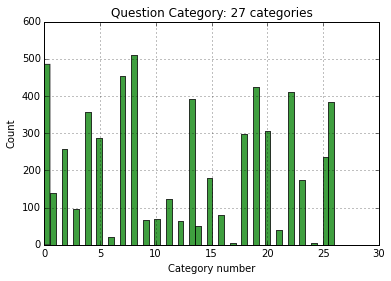

In [45]:
from sklearn.cluster import KMeans

# Question category
n_components = 27
est = KMeans(n_clusters=n_components)
est.fit(X_pos_qid)
pred_cat_qid = est.predict(X_pos_qid)

plt.hist(pred_cat_qid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("Question Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

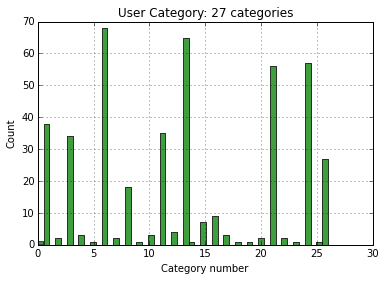

In [46]:
# User category
n_components = 27
est = KMeans(n_clusters=n_components)
est.fit(X_pos_uid)
pred_cat_uid = est.predict(X_pos_uid)

plt.hist(pred_cat_uid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("User Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

In [47]:
from collections import Counter


users.sub_append('cat_uid', {key: str(pred_cat_uid[i]) for i, key in enumerate(users.keys())})
questions.sub_append('cat_qid', {key: str(pred_cat_qid[i]) for i, key in enumerate(questions.keys())})

# to get most frequent cat for some test data which do not have ids in train set
most_pred_cat_uid = Counter(pred_cat_uid).most_common(1)[0][0]
most_pred_cat_qid = Counter(pred_cat_qid).most_common(1)[0][0]

print(most_pred_cat_uid)
print(most_pred_cat_qid)

6
8


## B. Modeling

In [48]:
def add_features(X):
    for item in X:
        # category
        for key in categories[item['category']].keys():
            item[key] = categories[item['category']][key]
            
        uid = int(item['uid'])
        qid = int(item['qid'])
        
        # uid
        if int(uid) in users:
            item.update(users[uid])
        else:
            acc = users.select(['acc_ratio_uid'])
            item['acc_ratio_uid'] = sum(acc) / float(len(acc))
            item['cat_uid'] = most_pred_cat_uid

        # qid
        if int(qid) in questions:
            item.update(questions[qid])

In [49]:
import pickle


questions = pickle.load(open('questions01.pkl', 'rb'))
users = pickle.load(open('users01.pkl', 'rb'))
categories = pickle.load(open('categories01.pkl', 'rb'))

In [50]:
from utils import load_buzz, select, write_result
from features import featurize, get_pos
from containers import Questions, Users, Categories
from nlp import extract_entities

import math
from collections import Counter

from numpy import abs, sqrt
from sklearn.linear_model import ElasticNetCV
from sklearn.cross_validation import ShuffleSplit, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans

wanted_user_items = list(set(users[0].keys()) - set(['cat_uid']))
X_pos_uid = users.select(wanted_user_items)
X_pos_qid = questions.select(['ave_pos_qid', 'acc_ratio_qid', 'ne_nor_mean', 'ne_mean', 'ne_median'])
X_pos_uid = normalize(X_pos_uid, norm='l1')
X_pos_qid = normalize(X_pos_qid, norm='l1')

tu = ('l1', 'n_uid_clust', 'n_qid_clust', 'rmse')
print ('=== Bench with ElasticNetCV: {0}, {1}, {2}, {3}'.format(*tu))
for ii in [27]:
    n_uid_clu = ii
    n_qid_clu = ii
    # clustering for uid
    uid_est = KMeans(n_clusters=n_uid_clu)
    uid_est.fit(X_pos_uid)
    pred_cat_uid = uid_est.predict(X_pos_uid)
    
    # clustering for qid
    qid_est = KMeans(n_clusters=n_qid_clu)
    qid_est.fit(X_pos_qid)
    pred_cat_qid = qid_est.predict(X_pos_qid)
    
    users.sub_append('cat_uid', {key: str(pred_cat_uid[i]) for i, key in enumerate(users.keys())})
    questions.sub_append('cat_qid', {key: str(pred_cat_qid[i]) for i, key in enumerate(questions.keys())})

    # to get most frequent cat for some test data which do not have ids in train set
    most_pred_cat_uid = Counter(pred_cat_uid).most_common(1)[0][0]
    most_pred_cat_qid = Counter(pred_cat_qid).most_common(1)[0][0]

    X_train, y_train = featurize(load_buzz(), group='train',
                                 sign_val=None, extra=['sign_val', 'avg_pos'])
    add_features(X_train)
    unwanted_features = ['ne_tags', 'pos_token', 'question', 'sign_val', 'group']
    wanted_features = list(set(X_train[1].keys()) - set(unwanted_features))
    X_train = select(X_train, wanted_features)

    vec = DictVectorizer()
    X_train_dict_vec = vec.fit_transform(X_train)
    X_new = X_train_dict_vec
    #X_new = LinearSVC(C=0.01, penalty="l1", dual=False, random_state=50).fit_transform(X_train_dict_vec, y_train)
    n_samples = X_new.shape[0]
    cv = ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=50)
    print("L1-based feature selection:", X_train_dict_vec.shape, X_new.shape)
    for l1 in [0.7]:
        scores = cross_val_score(ElasticNetCV(n_jobs=3, normalize=True, l1_ratio = l1),
                                 X_new, y_train,
                                 cv=cv, scoring='mean_squared_error')
        rmse = sqrt(abs(scores)).mean()
        print ('{0}, {1}, {2}, {3}'.format(l1, n_uid_clu, n_qid_clu, rmse))

=== Bench with ElasticNetCV: l1, n_uid_clust, n_qid_clust, rmse
L1-based feature selection: (28494, 1112) (28494, 1112)
0.7, 27, 27, 74.94733545500719


Original
```
=== Bench with ElasticNetCV: l1, n_uid_clust, n_qid_clust, rmse
L1-based feature selection: (28494, 1112) (28494, 1112)
0.7, 27, 27, 74.88480204218828
```
Without users features for regression
```
=== Bench with ElasticNetCV: l1, n_uid_clust, n_qid_clust, rmse
L1-based feature selection: (28494, 1112) (28494, 1112)
0.7, 27, 27, 74.94733641570902
```

### Training and testing model

In [51]:
X_test = featurize(load_buzz(), group='test', sign_val=None, extra=['avg_pos'])
add_features(X_test)
X_test = select(X_test, wanted_features)

WARN: no key group
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key group
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key group
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key group
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key group
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key group
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key group
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key group
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key group
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key group
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key group
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key group
WARN: no key ne_tags
WARN: no key question
WAR

In [52]:
unwanted_features = ['ne_tags', 'pos_token', 'question', 'sign_val', 'group']
wanted_features = list(set(X_train[1].keys()) - set(unwanted_features))
X_train = select(X_train, wanted_features)
X_train[0]

{'acc_cat_astronomy': 0.6634615384615384,
 'acc_cat_biology': 0.5,
 'acc_cat_chemistry': 0.6842105263157895,
 'acc_cat_earth science': 1.0,
 'acc_cat_fine arts': 0.8367346938775511,
 'acc_cat_history': 0.8157894736842105,
 'acc_cat_literature': 0.9072164948453608,
 'acc_cat_mathematics': 0.6666666666666666,
 'acc_cat_other': 0.7508305647840532,
 'acc_cat_physics': 0.7619047619047619,
 'acc_cat_social studies': 0.8378378378378378,
 'acc_ratio_cat': 0.7560975609756098,
 'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.8301282051282052,
 'answer': 'thomas cole',
 'ave_pos_cat': 43.640185830429736,
 'ave_pos_qid': 70.5,
 'ave_pos_uid': 80.464743589743591,
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 55.708333333333336,
 'cat_qid': '5',
 'cat_uid': '16',
 'category': 'Fine Arts',
 'ne_count': 12,
 'ne_mean': 56.5,
 'ne_median': 60.5,
 'ne_mod': 65,
 'ne_nor_mean': 0.7243589743589743,
 'q_length': 78,
 'qid': 1,
 'uid': 0}

In [53]:
users[131]

{'acc_cat_astronomy': 0.0,
 'acc_cat_biology': 0.0,
 'acc_cat_chemistry': 0.4,
 'acc_cat_earth science': 0.7358490566037735,
 'acc_cat_fine arts': 0.75,
 'acc_cat_history': 0.5,
 'acc_cat_literature': 0.7368421052631579,
 'acc_cat_mathematics': 0.5,
 'acc_cat_other': 0.7508305647840532,
 'acc_cat_physics': 0.8181818181818182,
 'acc_cat_social studies': 0.7142857142857143,
 'acc_ratio_uid': 0.6712328767123288,
 'ave_pos_uid': 98.863013698630141,
 'cat_uid': '0'}

In [54]:
categories['astronomy']

{'acc_ratio_cat': 0.6634615384615384, 'ave_pos_cat': 24.798076923076923}

In [55]:
X_test[1]

{'acc_cat_astronomy': 0.0,
 'acc_cat_biology': 0.0,
 'acc_cat_chemistry': 0.4,
 'acc_cat_earth science': 0.7358490566037735,
 'acc_cat_fine arts': 0.75,
 'acc_cat_history': 0.5,
 'acc_cat_literature': 0.7368421052631579,
 'acc_cat_mathematics': 0.5,
 'acc_cat_other': 0.7508305647840532,
 'acc_cat_physics': 0.8181818181818182,
 'acc_cat_social studies': 0.7142857142857143,
 'acc_ratio_cat': 0.65625,
 'acc_ratio_qid': 0.6428571428571429,
 'acc_ratio_uid': 0.6712328767123288,
 'answer': 'david hilbert',
 'ave_pos_cat': 18.712499999999999,
 'ave_pos_qid': 79.857142857142861,
 'ave_pos_uid': 98.863013698630141,
 'avg_pos_qid': 15.571428571428571,
 'avg_pos_uid': 36.31506849315068,
 'cat_qid': '7',
 'cat_uid': '0',
 'category': 'Mathematics',
 'ne_count': 9,
 'ne_mean': 85.11111111111111,
 'ne_median': 97.0,
 'ne_mod': 97,
 'ne_nor_mean': 0.8105820105820106,
 'q_length': 105,
 'qid': 9967,
 'uid': 131}

In [56]:
vec = DictVectorizer()
vec.fit(X_train + X_test)
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [58]:
for l1_ratio in [0.7]:
    print('=== l1_ratio:', l1_ratio)
    regressor = ElasticNetCV(n_jobs=3, normalize=True, l1_ratio=l1_ratio, random_state=50)
    regressor.fit(X_train, y_train)
    print(regressor.coef_)
    print(regressor.alpha_)
    predictions = regressor.predict(X_test)
    write_result(load_buzz()['test'], predictions, file_name=str(l1_ratio)+'guess_adj.csv', adj=True)

=== l1_ratio: 0.7
[  1.95889174e-02   3.46702533e+00   1.52843231e+00 ...,   2.89161265e-02
   3.58374531e-06  -2.54584259e-03]
0.000404215283508
** Adjust results ***
** tid qid uid: pred_pos, q_length, diff
32193 123840 15 : 33.037393942496536 , 33 , 0.037393942496535715
32186 123840 28 : 37.06965892366334 , 33 , 4.06965892366334
32081 123757 1 : 31.940422945933463 , 29 , 2.940422945933463
32067 123750 43 : 25.72306865206258 , 19 , 6.7230686520625795
32025 123718 39 : 15.649837240650243 , 13 , 2.6498372406502426
32018 123718 13 : 18.633596517791332 , 13 , 5.633596517791332
31997 123709 52 : 35.97853155498831 , 17 , 18.978531554988308
14665 8933 56 : 59.27557922333045 , 58 , 1.2755792233304533
13083 106213 9 : 38.175321907347026 , 21 , 17.175321907347026
12908 106060 124 : 37.831176279900504 , 37 , 0.8311762799005038
24990 106373 62 : 30.019789828467978 , 23 , 7.019789828467978

** diff_tot 67.33437701663176


80.97372